# GPU Cluster Spot Resource Dataset Analysis (Quick Version)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Load the datasets
print("Loading datasets...")
# node_df = pd.read_csv('node_info_df.csv')
# job_df = pd.read_csv('job_info_df.csv')
node_df = pd.read_csv('/kaggle/input/alibaba-gpu-cluster-spot-resource-dataset/node_info_df.csv')
job_df = pd.read_csv('/kaggle/input/alibaba-gpu-cluster-spot-resource-dataset/job_info_df.csv')

print(f"Node dataset shape: {node_df.shape}")
print(f"Job dataset shape: {job_df.shape}")

Loading datasets...
Node dataset shape: (4278, 4)
Job dataset shape: (466867, 9)


In [4]:
# ================== NODE DATASET ANALYSIS ==================
print("\n" + "="*60)
print("NODE DATASET ANALYSIS")
print("="*60)

# Basic statistics
print("\n1. Basic Node Statistics:")
print(f"Total nodes: {len(node_df)}")
print(f"Unique GPU models: {node_df['gpu_model'].nunique()}")
print(f"Total GPU cards: {node_df['gpu_capacity_num'].sum()}")
print(f"Total CPU cores (vCPUs): {node_df['cpu_num'].sum()}")

# GPU model distribution
print("\n2. GPU Model Distribution:")
gpu_dist = node_df.groupby('gpu_model').agg({
    'node_name': 'count',
    'gpu_capacity_num': 'sum',
    'cpu_num': 'sum'
}).rename(columns={'node_name': 'node_count', 'gpu_capacity_num': 'total_gpus', 'cpu_num': 'total_cpus'})
gpu_dist['avg_gpus_per_node'] = gpu_dist['total_gpus'] / gpu_dist['node_count']
gpu_dist['avg_cpus_per_node'] = gpu_dist['total_cpus'] / gpu_dist['node_count']
gpu_dist = gpu_dist.sort_values('total_gpus', ascending=False)
print(gpu_dist)

# Node configuration patterns
print("\n3. Node Configuration Patterns:")
config_patterns = node_df.groupby(['gpu_capacity_num', 'cpu_num']).size().reset_index(name='count')
config_patterns = config_patterns.sort_values('count', ascending=False)
print(f"Unique configurations: {len(config_patterns)}")
print("\nTop 10 most common configurations:")
print(config_patterns.head(10))

# GPU capacity distribution
print("\n4. GPU Capacity per Node Distribution:")
gpu_cap_dist = node_df['gpu_capacity_num'].value_counts().sort_index()
print(gpu_cap_dist)


NODE DATASET ANALYSIS

1. Basic Node Statistics:
Total nodes: 4278
Unique GPU models: 6
Total GPU cards: 10412
Total CPU cores (vCPUs): 632636

2. GPU Model Distribution:
                node_count  total_gpus  total_cpus  avg_gpus_per_node  \
gpu_model                                                               
A100-SXM4-80GB         432        3456       55296           8.000000   
A10                   2494        2494      319228           1.000000   
H800                   219        1752       42048           8.000000   
GPU-series-1           989        1558      189824           1.575329   
GPU-series-2           122         976       23424           8.000000   
A800-SXM4-80GB          22         176        2816           8.000000   

                avg_cpus_per_node  
gpu_model                          
A100-SXM4-80GB         128.000000  
A10                    127.998396  
H800                   192.000000  
GPU-series-1           191.935288  
GPU-series-2           192.

In [5]:
# ================== JOB DATASET ANALYSIS ==================
print("\n" + "="*60)
print("JOB DATASET ANALYSIS")
print("="*60)

# Basic statistics
print("\n1. Basic Job Statistics:")
print(f"Total jobs: {len(job_df)}")
print(f"Unique organizations: {job_df['organization'].nunique()}")
print(f"HP jobs: {len(job_df[job_df['job_type'] == 'HP'])} ({len(job_df[job_df['job_type'] == 'HP'])/len(job_df)*100:.2f}%)")
print(f"Spot jobs: {len(job_df[job_df['job_type'] == 'Spot'])} ({len(job_df[job_df['job_type'] == 'Spot'])/len(job_df)*100:.2f}%)")

# Job type comparison
print("\n2. Job Type Comparison:")
job_comparison = job_df.groupby('job_type').agg({
    'job_name': 'count',
    'cpu_request': ['mean', 'median', 'std'],
    'gpu_request': ['mean', 'median', 'std'],
    'worker_num': ['mean', 'median', 'max'],
    'duration': ['mean', 'median', 'std']
}).round(2)
job_comparison.columns = ['_'.join(col).strip() for col in job_comparison.columns.values]
print(job_comparison)

# Duration analysis
print("\n3. Job Duration Analysis:")
job_df['duration_hours'] = job_df['duration'] / 3600
job_df['duration_days'] = job_df['duration'] / 86400

duration_stats = job_df.groupby('job_type')['duration_hours'].describe()
print("Duration in hours:")
print(duration_stats)

# GPU model preference by job type
print("\n4. GPU Model Preference by Job Type:")
gpu_preference = pd.crosstab(job_df['gpu_model'], job_df['job_type'], margins=True)
print(gpu_preference)

# Organization analysis
print("\n5. Top 10 Organizations by Job Count:")
top_orgs = job_df['organization'].value_counts().head(10)
print(top_orgs)

print("\n6. Organization Job Type Distribution (Top 10 orgs):")
top_org_list = top_orgs.index.tolist()
org_job_dist = job_df[job_df['organization'].isin(top_org_list)].groupby(['organization', 'job_type']).size().unstack(fill_value=0)
print(org_job_dist)

# Resource requirements analysis
print("\n7. Resource Requirements Analysis:")
print("\nGPU Requirements Distribution:")
gpu_req_dist = job_df.groupby(['job_type', 'gpu_request']).size().unstack(fill_value=0)
print(gpu_req_dist.head(10))

print("\nWorker Number Distribution:")
worker_stats = job_df.groupby('job_type')['worker_num'].describe()
print(worker_stats)

# Multi-worker jobs analysis
print("\n8. Multi-Worker Jobs Analysis:")
multi_worker = job_df[job_df['worker_num'] > 1]
print(f"Total multi-worker jobs: {len(multi_worker)} ({len(multi_worker)/len(job_df)*100:.2f}%)")
print(f"Multi-worker HP jobs: {len(multi_worker[multi_worker['job_type'] == 'HP'])}")
print(f"Multi-worker Spot jobs: {len(multi_worker[multi_worker['job_type'] == 'Spot'])}")

# Temporal analysis
print("\n9. Temporal Analysis:")
job_df['submit_time_hours'] = job_df['submit_time'] / 3600
job_df['submit_time_days'] = job_df['submit_time'] / 86400

print(f"Total observation period: {job_df['submit_time_days'].max():.2f} days")
print(f"Average job submission rate: {len(job_df)/job_df['submit_time_days'].max():.2f} jobs/day")

# Resource utilization patterns
print("\n10. Resource Utilization Patterns:")
job_df['total_gpu_hours'] = job_df['gpu_request'] * job_df['worker_num'] * job_df['duration_hours']
job_df['total_cpu_hours'] = job_df['cpu_request'] * job_df['worker_num'] * job_df['duration_hours']

utilization = job_df.groupby('job_type').agg({
    'total_gpu_hours': 'sum',
    'total_cpu_hours': 'sum'
})
print("Total resource hours consumed:")
print(utilization)


JOB DATASET ANALYSIS

1. Basic Job Statistics:
Total jobs: 466867
Unique organizations: 84
HP jobs: 415713 (89.04%)
Spot jobs: 51154 (10.96%)

2. Job Type Comparison:
          job_name_count  cpu_request_mean  cpu_request_median  \
job_type                                                         
HP                415713             24.28                 8.0   
Spot               51154             26.60                12.0   

          cpu_request_std  gpu_request_mean  gpu_request_median  \
job_type                                                          
HP                  41.86              2.00                 1.0   
Spot                33.19              2.19                 1.0   

          gpu_request_std  worker_num_mean  worker_num_median  worker_num_max  \
job_type                                                                        
HP                   2.43             1.38                1.0             182   
Spot                 2.29             4.19             


GENERATING VISUALIZATIONS


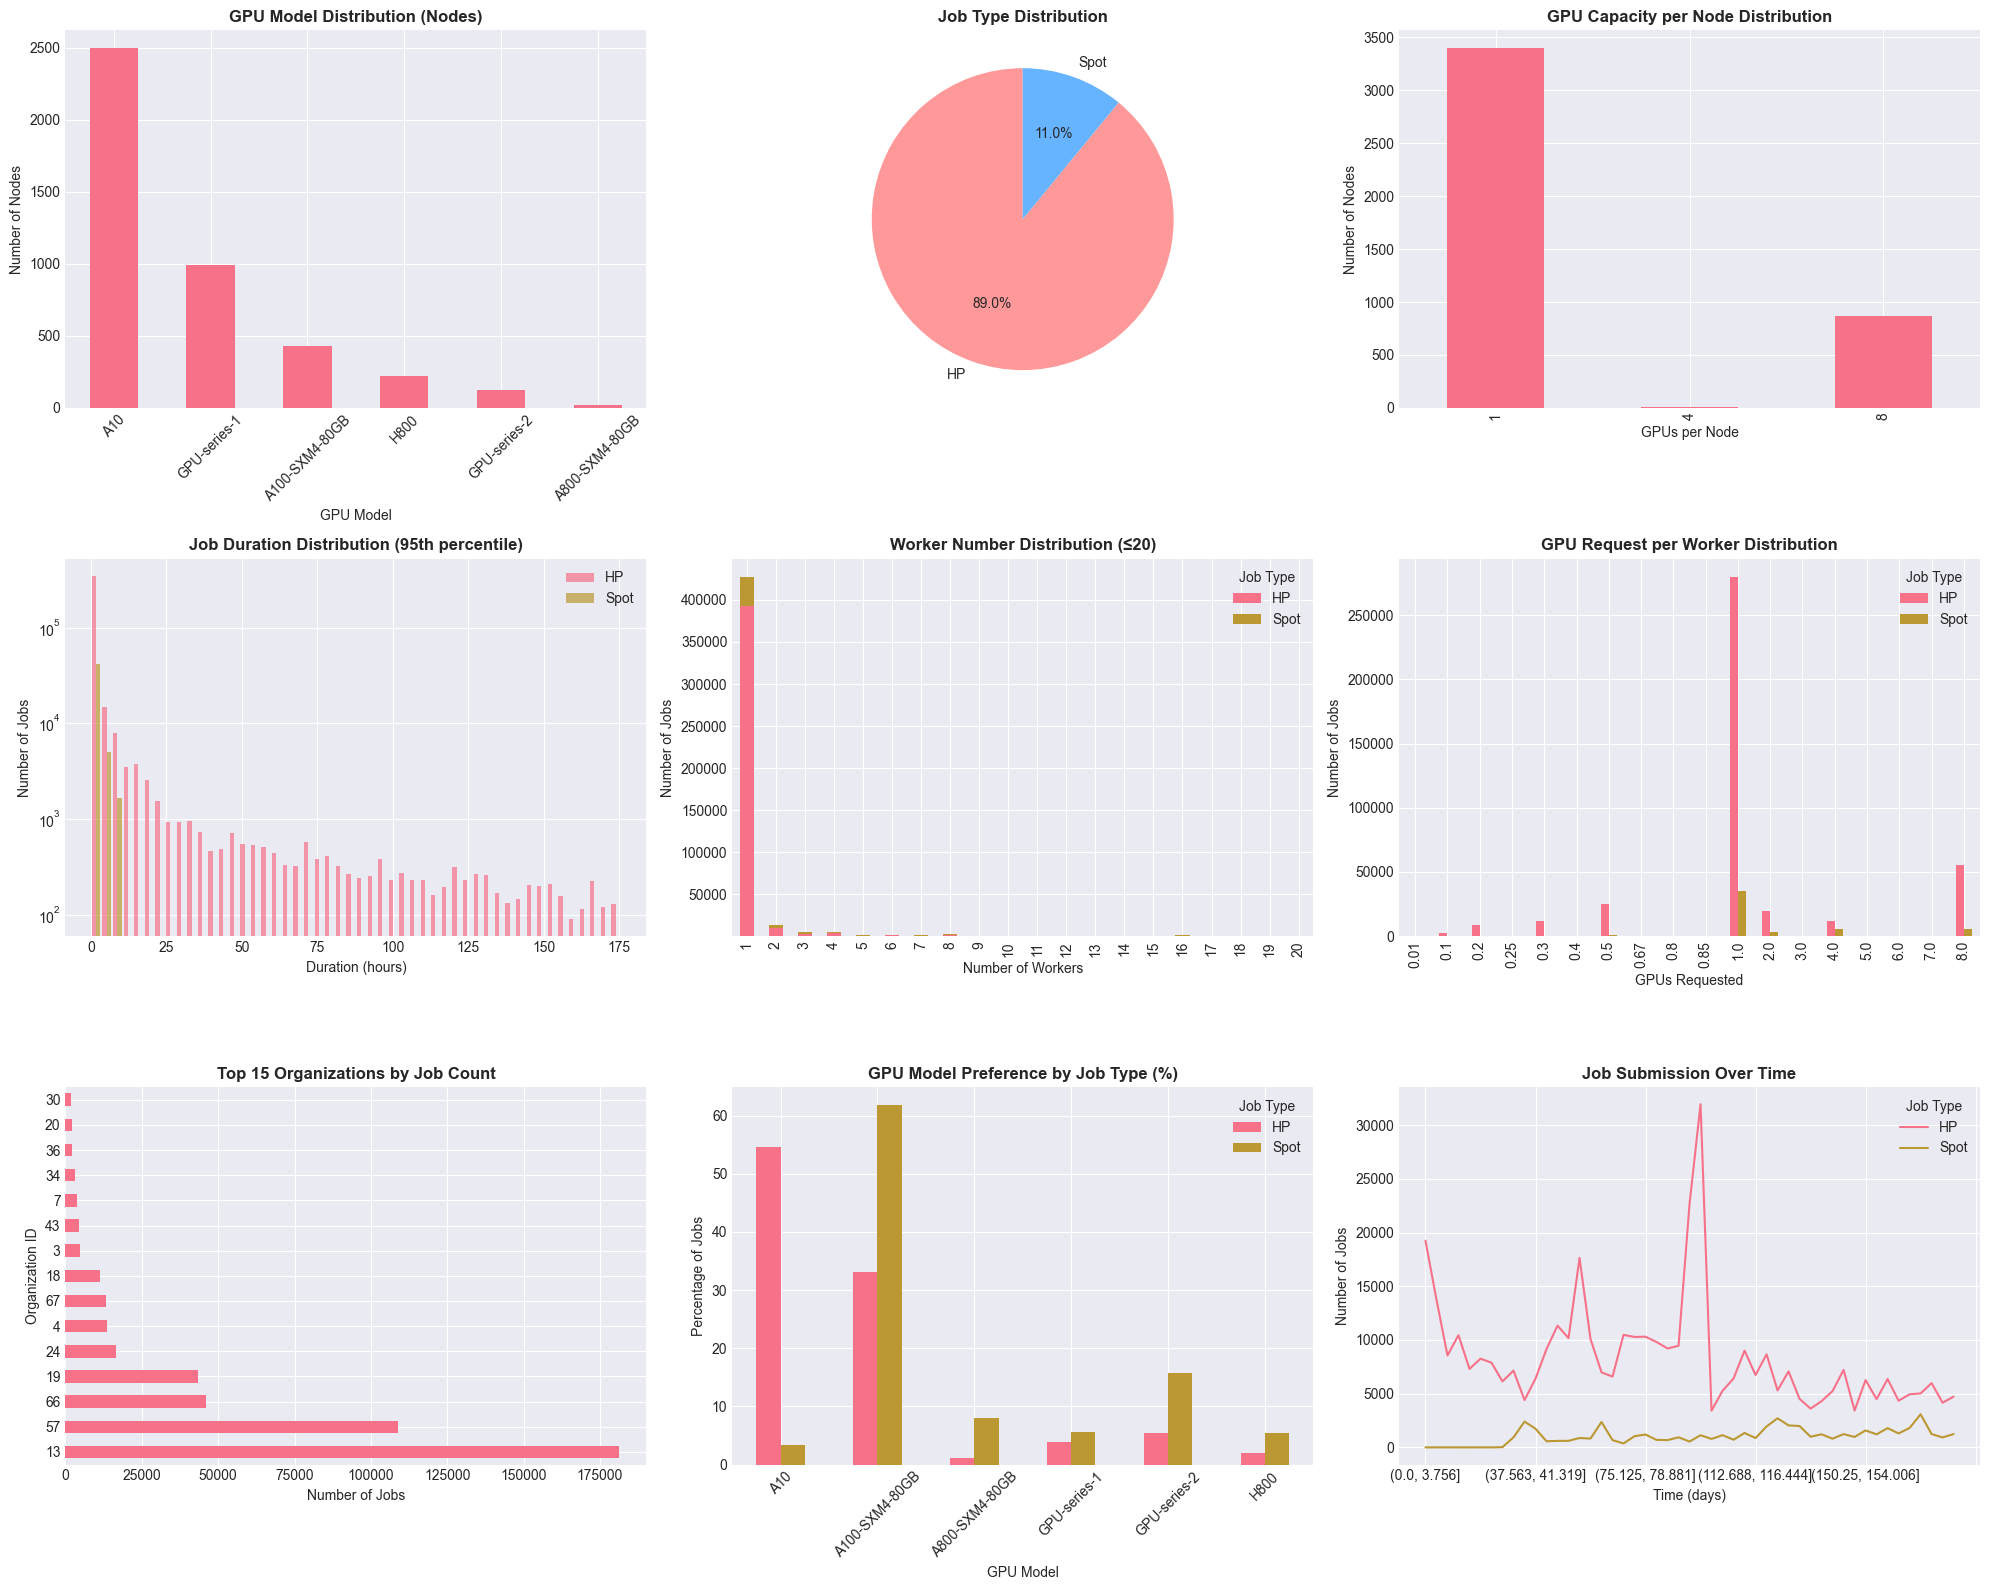

In [6]:
# ================== VISUALIZATION ==================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 16))

# 1. GPU Model Distribution in Nodes
ax1 = plt.subplot(3, 3, 1)
gpu_dist_plot = node_df['gpu_model'].value_counts()
gpu_dist_plot.plot(kind='bar', ax=ax1)
ax1.set_title('GPU Model Distribution (Nodes)', fontsize=12, fontweight='bold')
ax1.set_xlabel('GPU Model')
ax1.set_ylabel('Number of Nodes')
ax1.tick_params(axis='x', rotation=45)

# 2. Job Type Distribution
ax2 = plt.subplot(3, 3, 2)
job_type_dist = job_df['job_type'].value_counts()
colors = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = ax2.pie(job_type_dist.values, labels=job_type_dist.index, 
                                     autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Job Type Distribution', fontsize=12, fontweight='bold')

# 3. GPU Capacity per Node
ax3 = plt.subplot(3, 3, 3)
node_df['gpu_capacity_num'].value_counts().sort_index().plot(kind='bar', ax=ax3)
ax3.set_title('GPU Capacity per Node Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('GPUs per Node')
ax3.set_ylabel('Number of Nodes')

# 4. Job Duration Distribution
ax4 = plt.subplot(3, 3, 4)
hp_duration = job_df[job_df['job_type'] == 'HP']['duration_hours']
spot_duration = job_df[job_df['job_type'] == 'Spot']['duration_hours']
ax4.hist([hp_duration[hp_duration < hp_duration.quantile(0.95)], 
          spot_duration[spot_duration < spot_duration.quantile(0.95)]], 
         bins=50, label=['HP', 'Spot'], alpha=0.7)
ax4.set_title('Job Duration Distribution (95th percentile)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Duration (hours)')
ax4.set_ylabel('Number of Jobs')
ax4.legend()
ax4.set_yscale('log')

# 5. Worker Number Distribution
ax5 = plt.subplot(3, 3, 5)
worker_dist = job_df[job_df['worker_num'] <= 20].groupby(['worker_num', 'job_type']).size().unstack(fill_value=0)
worker_dist.plot(kind='bar', stacked=True, ax=ax5)
ax5.set_title('Worker Number Distribution (≤20)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Number of Workers')
ax5.set_ylabel('Number of Jobs')
ax5.legend(title='Job Type')

# 6. GPU Request Distribution
ax6 = plt.subplot(3, 3, 6)
gpu_req = job_df[job_df['gpu_request'] <= 8].groupby(['gpu_request', 'job_type']).size().unstack(fill_value=0)
gpu_req.plot(kind='bar', ax=ax6)
ax6.set_title('GPU Request per Worker Distribution', fontsize=12, fontweight='bold')
ax6.set_xlabel('GPUs Requested')
ax6.set_ylabel('Number of Jobs')
ax6.legend(title='Job Type')

# 7. Top Organizations
ax7 = plt.subplot(3, 3, 7)
top_orgs_plot = job_df['organization'].value_counts().head(15)
top_orgs_plot.plot(kind='barh', ax=ax7)
ax7.set_title('Top 15 Organizations by Job Count', fontsize=12, fontweight='bold')
ax7.set_xlabel('Number of Jobs')
ax7.set_ylabel('Organization ID')

# 8. GPU Model Preference by Job Type
ax8 = plt.subplot(3, 3, 8)
gpu_pref_norm = pd.crosstab(job_df['gpu_model'], job_df['job_type'], normalize='columns') * 100
gpu_pref_norm.plot(kind='bar', ax=ax8)
ax8.set_title('GPU Model Preference by Job Type (%)', fontsize=12, fontweight='bold')
ax8.set_xlabel('GPU Model')
ax8.set_ylabel('Percentage of Jobs')
ax8.tick_params(axis='x', rotation=45)
ax8.legend(title='Job Type')

# 9. Resource Utilization Over Time
ax9 = plt.subplot(3, 3, 9)
# Create time bins
time_bins = np.linspace(0, job_df['submit_time_days'].max(), 50)
job_df['time_bin'] = pd.cut(job_df['submit_time_days'], bins=time_bins)
time_series = job_df.groupby(['time_bin', 'job_type']).size().unstack(fill_value=0)
time_series.plot(ax=ax9)
ax9.set_title('Job Submission Over Time', fontsize=12, fontweight='bold')
ax9.set_xlabel('Time (days)')
ax9.set_ylabel('Number of Jobs')
ax9.legend(title='Job Type')

plt.tight_layout()
plt.savefig('gpu_cluster_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# ================== ADVANCED ANALYSIS ==================
print("\n" + "="*60)
print("ADVANCED ANALYSIS")
print("="*60)

# 1. GPU Model Efficiency Analysis
print("\n1. GPU Model Efficiency (Avg Duration by GPU Model and Job Type):")
gpu_efficiency = job_df.groupby(['gpu_model', 'job_type'])['duration_hours'].agg(['mean', 'median', 'count']).round(2)
print(gpu_efficiency)

# 2. Organization Resource Consumption
print("\n2. Top 10 Organizations by Total GPU Hours:")
org_gpu_hours = job_df.groupby('organization')['total_gpu_hours'].sum().sort_values(ascending=False).head(10)
print(org_gpu_hours)

# 3. Job Complexity Score
job_df['complexity_score'] = (job_df['gpu_request'] * job_df['worker_num'] * 
                              job_df['cpu_request'] * job_df['duration_hours'] / 1000)
print("\n3. Job Complexity Analysis:")
complexity_stats = job_df.groupby('job_type')['complexity_score'].describe()
print(complexity_stats)

# 4. Resource Matching Analysis
print("\n4. Resource Matching Analysis:")
print("Checking if requested resources can be satisfied by available nodes...")

# GPU matching
for gpu_model in job_df['gpu_model'].unique():
    node_capacity = node_df[node_df['gpu_model'] == gpu_model]['gpu_capacity_num'].max() if gpu_model in node_df['gpu_model'].values else 0
    max_request = job_df[job_df['gpu_model'] == gpu_model]['gpu_request'].max()
    print(f"{gpu_model}: Max node capacity={node_capacity}, Max job request={max_request}, Can satisfy={'Yes' if node_capacity >= max_request else 'No'}")

# 5. Spot vs HP Resource Competition
print("\n5. Resource Competition Analysis:")
# Calculate overlapping resource requests
spot_gpu_hours = job_df[job_df['job_type'] == 'Spot']['total_gpu_hours'].sum()
hp_gpu_hours = job_df[job_df['job_type'] == 'HP']['total_gpu_hours'].sum()
total_gpu_hours = spot_gpu_hours + hp_gpu_hours

print(f"Spot GPU hours: {spot_gpu_hours:,.0f} ({spot_gpu_hours/total_gpu_hours*100:.2f}%)")
print(f"HP GPU hours: {hp_gpu_hours:,.0f} ({hp_gpu_hours/total_gpu_hours*100:.2f}%)")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

summary = {
    'Total Nodes': len(node_df),
    'Total GPUs': node_df['gpu_capacity_num'].sum(),
    'Total Jobs': len(job_df),
    'HP Jobs': len(job_df[job_df['job_type'] == 'HP']),
    'Spot Jobs': len(job_df[job_df['job_type'] == 'Spot']),
    'Total Organizations': job_df['organization'].nunique(),
    'Observation Period (days)': job_df['submit_time_days'].max(),
    'Avg Jobs per Day': len(job_df)/job_df['submit_time_days'].max(),
    'Total GPU Hours': job_df['total_gpu_hours'].sum(),
    'Total CPU Hours': job_df['total_cpu_hours'].sum(),
}

for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:,.2f}")
    else:
        print(f"{key}: {value:,}")

print("\nAnalysis complete! Visualizations saved to 'gpu_cluster_analysis.png'")



ADVANCED ANALYSIS

1. GPU Model Efficiency (Avg Duration by GPU Model and Job Type):
                           mean  median   count
gpu_model      job_type                        
A10            HP         66.21    0.11  226881
               Spot       13.21    1.33    1762
A100-SXM4-80GB HP         25.32    0.52  137396
               Spot        3.44    0.48   31624
A800-SXM4-80GB HP         12.14    0.39    4690
               Spot        1.73    0.39    4109
GPU-series-1   HP        315.42    1.10   16054
               Spot        3.87    2.61    2857
GPU-series-2   HP          8.07    0.37   22340
               Spot        3.42    1.42    8057
H800           HP          5.46    0.26    8352
               Spot        6.05    0.32    2745

2. Top 10 Organizations by Total GPU Hours:
organization
13    1.271139e+07
57    1.137187e+07
19    3.987630e+06
66    2.105088e+06
4     1.637783e+06
67    1.008737e+06
18    1.002370e+06
37    9.521568e+05
24    4.947359e+05
34    4.63947